## Import libraries

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install imbalanced-learn
!pip install seaborn
!pip install matplotlib
!pip install openpyxl

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

## 1. Data Loading

In [2]:
# Define the local file paths (ajusta según tu carpeta de trabajo)
BASIC_DATA = 'https://raw.githubusercontent.com/agustinrodriguezc/HMKU/main/risk_train_BASIC_DATA.xlsx'
COMM_DATA = 'https://raw.githubusercontent.com/agustinrodriguezc/HMKU/main/risk_train_COMM_DATA.xlsx'

# Cargar los datasets desde el sistema de archivos local
BD = pd.read_excel(BASIC_DATA)
CD = pd.read_excel(COMM_DATA)

# Unir los dataframes por la clave ID
df = pd.merge(BD, CD, left_on='ID', right_on='ID_OFF', how='inner')

# Eliminar la columna duplicada
df.drop(columns=['ID_OFF'], inplace=True)

# Mostrar las primeras filas del DataFrame resultante
print("Primeras filas del DataFrame combinado:")
print(df.head())

Primeras filas del DataFrame combinado:
     ID  AGE   INCOME GENDER  MARITAL  NUMKIDS  HOUSEHOLD_MEMBERS  NUMCARDS  \
0  1_73   50  59692.0      m  married      1.0                  3         1   
1  2_23   50  59463.0      m  married      0.0                  2         2   
2  3_34   50  59179.0      m  married      1.0                  2         1   
3  4_10   50  58529.0      m  married      0.0                  1         1   
4  5_50   50  57683.0      f  married      1.0                  2         1   

   HOWPAID MORTGAGE  STORECAR  LOANS      RISK  #OFFICE     PRODUCT  
0  monthly        y         1      0  bad loss     73.0     CLASSIC  
1  monthly        y         1      1  bad loss     23.0     CLASSIC  
2  monthly        y         2      1  bad loss     34.0  BASIC_PLUS  
3  monthly        y         1      0  bad loss     10.0       BASIC  
4  monthly        y         2      1  bad loss     50.0  BASIC_PLUS  


## 2. Data Cleaning

In [3]:
# Handle missing values
imputer_income = SimpleImputer(strategy='median')
df['INCOME'] = imputer_income.fit_transform(df[['INCOME']])

imputer_office = SimpleImputer(strategy='most_frequent')
df['#OFFICE'] = imputer_office.fit_transform(df[['#OFFICE']])

# Handle outliers in 'INCOME' using IQR method
Q1 = df['INCOME'].quantile(0.25)
Q3 = df['INCOME'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['INCOME'] = np.where(df['INCOME'] < lower_bound, lower_bound, df['INCOME'])
df['INCOME'] = np.where(df['INCOME'] > upper_bound, upper_bound, df['INCOME'])

# Remove remaining rows with NaN values
df = df.dropna()
print("Missing values after cleaning:")
print(df.isna().sum())

# Filter to exclude records where RISK == "bad profit"
df = df[df['RISK'] != 'bad profit'].copy()

Missing values after cleaning:
ID                   0
AGE                  0
INCOME               0
GENDER               0
MARITAL              0
NUMKIDS              0
HOUSEHOLD_MEMBERS    0
NUMCARDS             0
HOWPAID              0
MORTGAGE             0
STORECAR             0
LOANS                0
RISK                 0
#OFFICE              0
PRODUCT              0
dtype: int64


## 3. Feature Engineering

In [4]:
# Binning for 'AGE' and 'INCOME'
df['AGE_TILE'] = pd.qcut(df['AGE'], q=4, labels=False, duplicates='drop')
df['INCOME_TILE'] = pd.qcut(df['INCOME'], q=4, labels=False, duplicates='drop')

# Create 'living_alone' variable
df['living_alone'] = df['HOUSEHOLD_MEMBERS'] == 1

# Create 'pc_income' variable
df['pc_income'] = df['INCOME'] / df['HOUSEHOLD_MEMBERS']

# Convert categorical variables to dummies
categorical_cols = ['GENDER', 'MARITAL', 'HOWPAID', 'MORTGAGE', 'PRODUCT']
df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Create 'bad_loss' target variable
df_dummies['bad_loss'] = df['RISK'] == 'bad loss'

## 4. Modeling

In [5]:
# Encode the original 'RISK' variable for reference
le = LabelEncoder() #LabelEncoder() assigns a unique integer to each category in df['RISK'].
df_dummies['RISK_encoded'] = le.fit_transform(df['RISK']) #Converts the categorical variable RISK.
# fit_transform() fits the encoder to the unique categories and transforms RISK into a new column called RISK_encoded.

# Prepare features and target
# Divide the data into features (X) and the target variable (y) for the machine learning model.
X = df_dummies.drop(['RISK', 'RISK_encoded', 'ID', 'bad_loss'], axis=1)
y = df_dummies['bad_loss'].astype(int)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=12345)
X_res, y_res = smote.fit_resample(X, y)


# Split the rebalanced data into training (80%) and test (20%) sets to train and evaluate the model.
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [6]:
# Configure the pipeline for KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])
# scaler: Standardize the features (subtract the mean and divide by the standard deviation,
#ensuring that all features have mean 0 and variance 1). This is crucial for KNN,
#as the algorithm is sensitive to the scales of the variables.

# clf: Applies KNeighborsClassifier(), the KNN model that predicts the class of a
#sample based on the classes of its k nearest neighbors.

# Specifies the hyperparameter combinations to be tested to optimize the KNN model.
param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'], #uniform= same weights for all neighboors ||
                                             #distance= Nearest neighbors have greater weight (inverse of distance).
    'clf__metric': ['euclidean', 'manhattan']
}

# Configure GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters from GridSearch:")
print(grid.best_params_)

Best Parameters from GridSearch:
{'clf__metric': 'manhattan', 'clf__n_neighbors': 9, 'clf__weights': 'distance'}


## 5. Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       838
           1       0.98      0.99      0.98       840

    accuracy                           0.98      1678
   macro avg       0.98      0.98      0.98      1678
weighted avg       0.98      0.98      0.98      1678

Confusion Matrix:


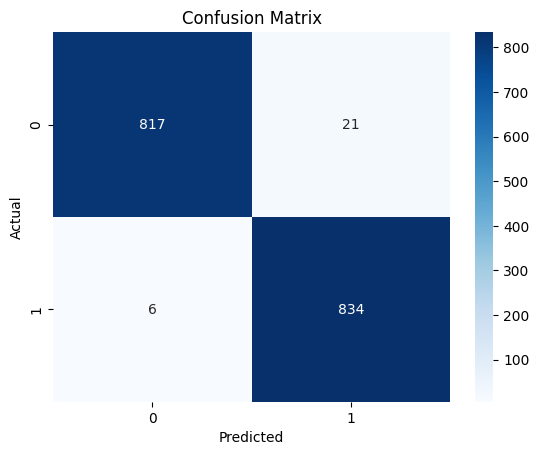

Test Accuracy: 0.984


In [7]:
# Predict on the test set
y_pred = grid.predict(X_test)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and display test accuracy
accuracy = grid.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")

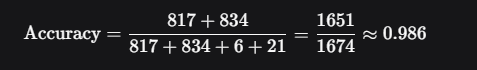

(0, 0): 817 (true negatives, TN)
(0, 1): 21 (false positives, FP)
(1, 0): 6 (false negatives, FN)
(1, 1): 834 (true positives, TP)

## 6. Validation

In [8]:
# Calculate and display baseline accuracy (predicting the majority class before SMOTE)
baseline_accuracy = y.value_counts().max() / len(y)
print(f"Baseline Accuracy (before SMOTE): {baseline_accuracy:.3f}")

Baseline Accuracy (before SMOTE): 0.885
